In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data
data = pd.read_csv('animal_speeds.csv', sep=';')
data

,animal,weight,movement_type,highspeed
0,House sparrow,0.04,flying,46.0
1,Pelican,7.80,flying,65.0
2,Vulture,11.00,flying,88.0
3,Pigeon,0.35,flying,80.0
4,Puffin,0.58,flying,88.0
...,...,...,...,...
154,Shortfin mako shark,570.00,swimming,72.0
155,Great white Shark,2000.00,swimming,50.0
156,Leopard seal,600.00,swimming,37.0
157,Basking shark,5200.00,swimming,2.5


In [3]:
# check for duplicates and then remove
data.duplicated().sum()
data.drop_duplicates(inplace = True)

In [4]:
# check for NaN values and then remove
data.isna().sum().sum()

0

In [5]:
# Overview of data
data.groupby(['movement_type'])[['weight', 'highspeed']].agg(np.mean)

,weight,highspeed
movement_type,,
climbing,40.285000,36.923077
flying,6.494192,88.769231
running,295.632577,52.582051
swimming,7153.940098,32.963415


## Daten transformation

wir können aus dieser Tabelle sehen, dass das Gewicht jeder Tierart stark variiert ist. Ein bemerkenswertes Beispiel dafür ist  das durchschnittliche Gewicht von 'flying' ist nur 6.5 während das von swimming ist 7154, also über 1000-mal größer. Dies deutet darauf hin, dass die Daten ungleichmäßig verteilt sind und die Daten-Transformierung durchgeführt werden soll.

Hierfür verwenden wir den Logarithmus von Basis 10 

In [7]:
# transformieren weight daten mit log_10
data['weight_log10'] = np.log10(data['weight'])

Text(0.5, 1.0, 'Diagramm nach dem Transformieren')

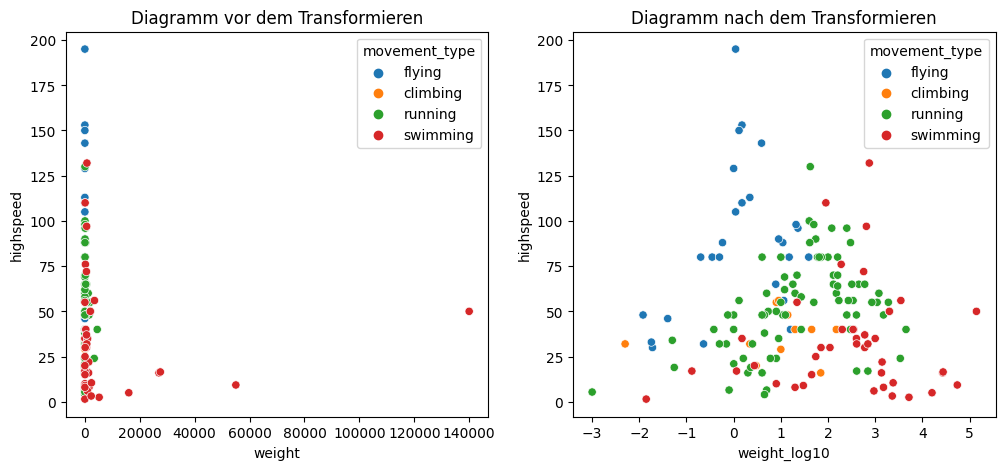

In [8]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
sns.scatterplot(x = data['weight'], y = data['highspeed'], hue = data['movement_type'])
plt.title('Diagramm vor dem Transformieren')

plt.subplot(1,2,2)
sns.scatterplot(x = data['weight_log10'], y = data['highspeed'], hue = data['movement_type'])
plt.title('Diagramm nach dem Transformieren')


## Modelevaluation

Modellieren wir nun einen linearen Modell, um die Höchstgeschwindigkeit einer Tierart gegeben ihr Körpergewicht und ihre Bewegungsart zu modellieren. 
Der Modell sieht wie folgt aus :

      highspeed = β_intercept + β0 · weight_log10 + β1 · Bewegungsart_1 + β2 · Bewegungsart_2 + β3 · Bewegungsart_3 
                  + β4 · Bewegungsart_4 + ϵ


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer


In [10]:
# Aufteilen der Daten in Features X und Zielvariable y
X = data[['weight_log10', 'movement_type']]
y = data['highspeed']

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1)

# wandeln Kategorische Variable 'movement_type' in numerische Werte um
preprocessor = ColumnTransformer(
        transformers = [('cat', OneHotEncoder(), ['movement_type'])],
        remainder = 'passthrough'
)

pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# berechnen MSE zur Bewertung
mse = mean_squared_error(y_test, y_pred)

categories = pipeline.named_steps['preprocessor'].named_transformers_['cat'].categories_
model = pipeline.named_steps['model']
intercept = model.intercept_
coef = model.coef_
print('Der lineare Modell lautet:')
print("highspeed = {} + {}*weight_log10 + {}*{} + {}*{} + {}*{} + {}*{}".
      format(intercept, coef[0], coef[1], categories[0][0], coef[2], categories[0][1], coef[3], categories[0][2], coef[4], categories[0][3]))
print("\nMean Squared Error:", mse)

Der lineare Modell lautet:
highspeed = 45.09513325459778 + -14.924996264306596*weight_log10 + 40.1006526041343*climbing + -0.44375823872367803*flying + -24.731898101103965*running + 5.841557817717753*swimming

Mean Squared Error: 412.82916485446225


Modelliere ich nun 4 lineare Modelle für jede Bewegungsart. 
Das Modell lautet:
        
        highspeedi = β0 + β1 · weight_log10i + β2 · (weight_log10i)^2 + . . . + βp · (weight_log10i)^p + ϵi
mit i ∈ {climbing, flying, running, swimming}, p ∈ {1, . . . , 8}.

Ich werde die Daten erst mit der Hold-Out-Validierung und dann mit der k-fachen Kreuzvalidierung durchführen. Ich möchte diese 2 Techniken vertraut machen und die vergleichen, welche zu der Modellierung des Modells besser passt.

### Hold-Out-Validierung

Wir teilen den Datensatz in 2 Teilen ein: Training- und Testdatensatz. Das Modell wird zunächst einmal auf den Trainingdatensatz trainiert und dann auf Testdatensatz getestet. Die Genauigkeit wird mit MSE bewertet.

In [11]:
from sklearn.preprocessing import PolynomialFeatures
movement_type = ['climbing', 'flying', 'running', 'swimming']
degrees = np.arange(1,9)

def mse_holdout(mov_type) :
    info = data[data['movement_type'] == mov_type]
    mse_values = []
    
    X = info[['weight_log10']]
    y = info['highspeed']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 3)
    
    # Schleife für verschiedene Polynomgrade    
    for degree in degrees:
        # Polynomial Feature erstellen
        poly_feat = PolynomialFeatures(degree = degree)
        
        X_train_poly = poly_feat.fit_transform(X_train)
        X_test_poly = poly_feat.transform(X_test)
        
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        y_pred = model.predict(X_test_poly)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)
        
    return mse_values

Visualisieren die MSE-test Werte

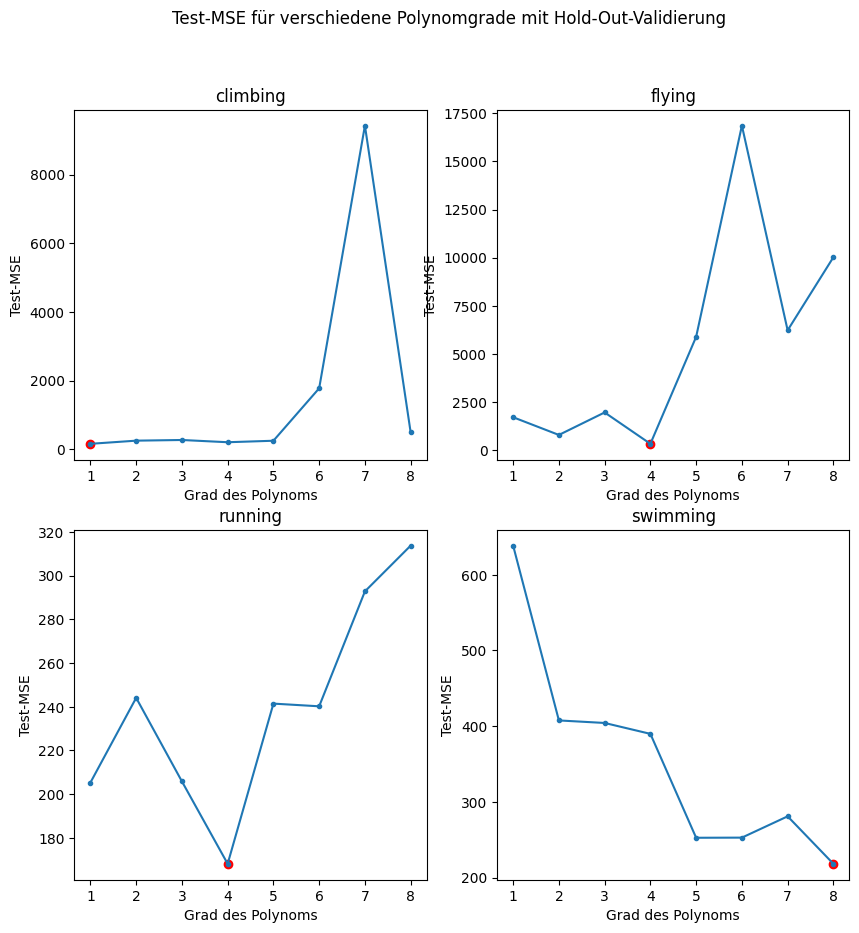

In [12]:
def mse_visualisieren(mse):
    min_index = mse.index(min(mse))
    plt.plot(degrees, mse, marker='.', linestyle = '-')
    plt.scatter(degrees[min_index], mse[min_index], color='red')
    plt.title(type)
    plt.xlabel('Grad des Polynoms')
    plt.ylabel('Test-MSE')
    

fig = plt.figure(figsize=(10,10))
fig.suptitle('Test-MSE für verschiedene Polynomgrade mit Hold-Out-Validierung')
i = 1
for type in movement_type:
    mse = mse_holdout(type)
    plt.subplot(2, 2, i)
    mse_visualisieren(mse)
    i = i + 1
    

Nun werde ich die tatsächlichen Daten zusammen mit der Vorhersage(der Modell) visualisieren

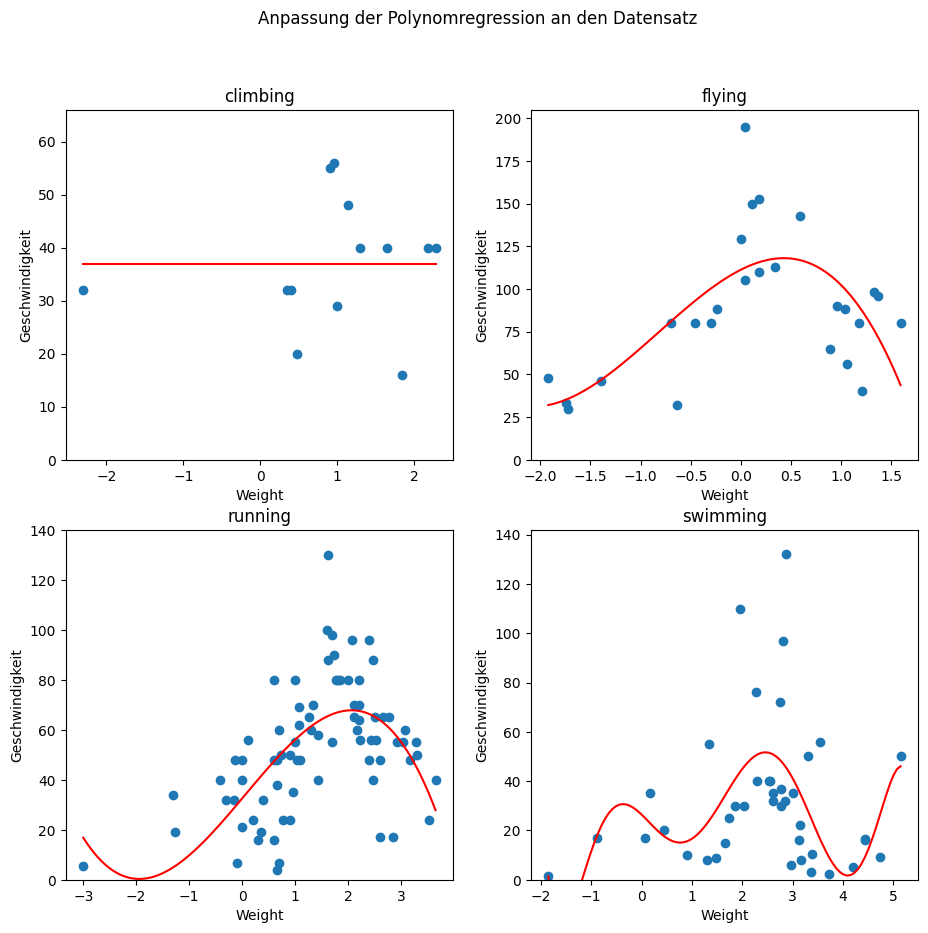

In [13]:
def model_visualisieren(mov_type):
    info = data[data['movement_type'] == mov_type]
    mse = mse_holdout(mov_type)
    degree = mse.index(min(mse))

    X = info[['weight_log10']]
    y = info['highspeed']
    
    poly_feat = PolynomialFeatures(degree = degree)    
    X_poly = poly_feat.fit_transform(X.values)
    model = LinearRegression()
    model.fit(X_poly, y)
    
    x_range = np.linspace(min(X.values), max(X.values), 100)
    x_range_poly = poly_feat.transform(x_range.reshape(-1, 1))
    y_pred = model.predict(x_range_poly)
    
    plt.scatter(X, y)
    plt.plot(x_range, y_pred, color='r')
    plt.xlabel('Weight')
    plt.ylabel('Geschwindigkeit')
    plt.ylim(0, max(y)+10)
    
fig = plt.figure(figsize=(11,10))
fig.suptitle('Anpassung der Polynomregression an den Datensatz')

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(movement_type[i])
    model_visualisieren(movement_type[i])
    

### k-fachen Kreuzvalidierung

In [14]:
def mse_kfach(mov_type):
    info = data[data['movement_type'] == mov_type]
    mse_values = []
    
    X = info[['weight_log10']]
    y = info['highspeed']
    
    # Schleife für verschiedene Polynomgrade    
    for degree in degrees:
        # Polynomial Feature erstellen
        poly_feat = PolynomialFeatures(degree = degree)     
        X_poly = poly_feat.fit_transform(X)
        
        model = LinearRegression()
        
        mse = cross_val_score(model, X_poly, y, scoring=make_scorer(mean_squared_error), cv = 10)
        average_mse = np.mean(mse)
        mse_values.append(average_mse)
        
    return mse_values
    

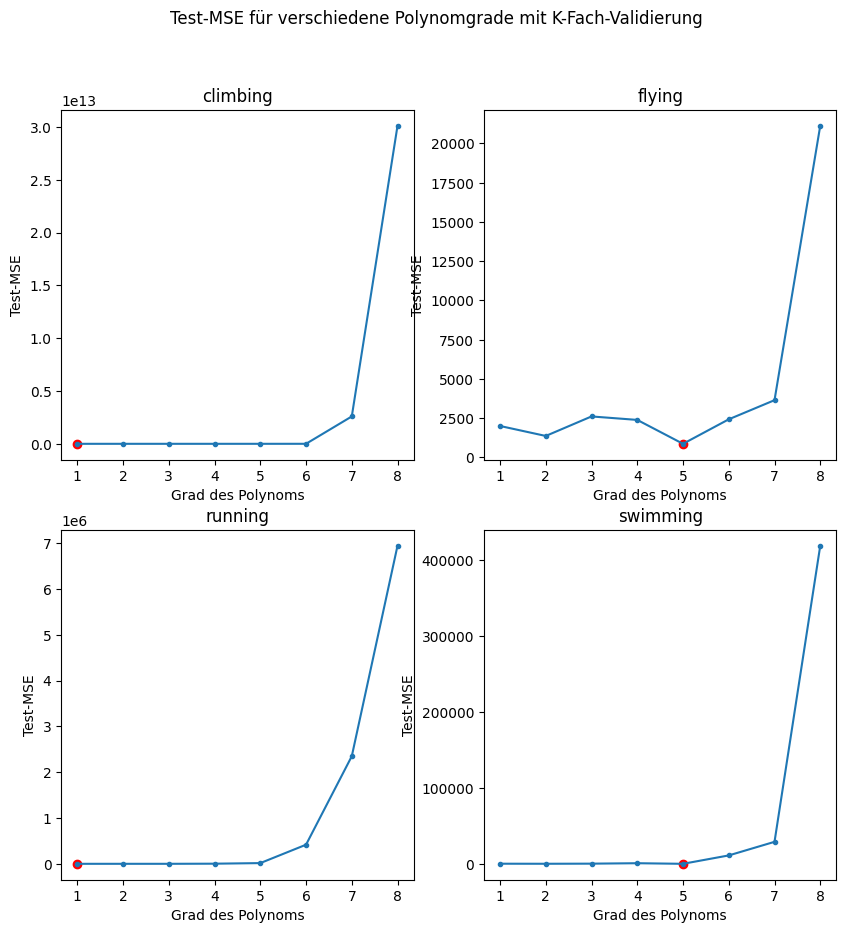

In [15]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Test-MSE für verschiedene Polynomgrade mit K-Fach-Validierung')
i = 1

for type in movement_type:
    mse = mse_kfach(type)
    plt.subplot(2, 2, i)
    mse_visualisieren(mse)
    i = i + 1

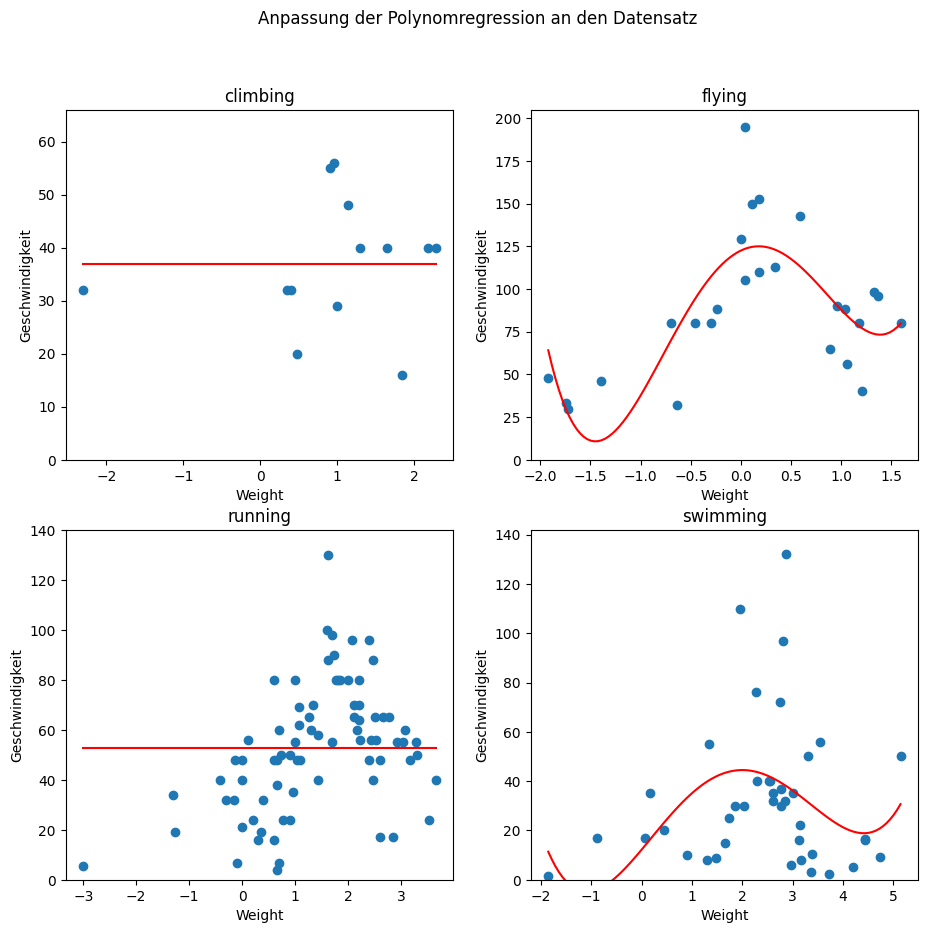

In [16]:
def model_visualisieren_kfach(mov_type):
    info = data[data['movement_type'] == mov_type]
    mse = mse_kfach(mov_type)
    degree = mse.index(min(mse))

    X = info[['weight_log10']]
    y = info['highspeed']
    
    poly_feat = PolynomialFeatures(degree = degree)    
    X_poly = poly_feat.fit_transform(X.values)
    model = LinearRegression()
    model.fit(X_poly, y)
    
    x_range = np.linspace(min(X.values), max(X.values), 100)
    x_range_poly = poly_feat.transform(x_range.reshape(-1, 1))
    y_pred = model.predict(x_range_poly)
    
    plt.scatter(X, y)
    plt.plot(x_range, y_pred, color='r')
    plt.xlabel('Weight')
    plt.ylabel('Geschwindigkeit')
    plt.ylim(0, max(y)+10)
    
fig = plt.figure(figsize=(11,10))
fig.suptitle('Anpassung der Polynomregression an den Datensatz')

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(movement_type[i])
    model_visualisieren_kfach(movement_type[i])
    